In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as pl
from matplotlib import rc
from matplotlib.pylab import rcParams
import matplotlib.ticker as mtick
from matplotlib.ticker import LogLocator
import seaborn as sb
import os
import pandas as pd

/disk01/home/ekarakoy/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
%matplotlib inline

In [3]:
# Let's setup graphics:
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text',usetex=False)
fontSize = 16
sb.set_style('dark')
rcParams['ytick.labelsize'] = fontSize
rcParams['xtick.labelsize'] = fontSize

In [4]:
# Prepare to manipulate data
bands2check = ['412','443','490','510','555','670']
rngDict = {'412':(4e-3,40),'443':(4e-3,40),'490':(4e-3,40),'510':(4e-3,40),
           '555':(4e-3,40),'670':(4e-3,40)}
figRows,figCols = 3,2
reshBands = np.reshape(bands2check,(figRows,figCols))
#rrsUncStd358Dict = dict.fromkeys(bands2check)
#rrsUncStd229Dict = dict.fromkeys(bands2check)
#rrsPercUncStd358Dict = dict.fromkeys(bands2check)
#rrsPercUncStd229Dict = dict.fromkeys(bands2check)
mainDir = '/disk02/UNCERTAINTIES/Monte-Carlo/PACE_SNR/DATA/L2_L3/FullScale/CentralPacific/'
fpStd358 = mainDir + 'S1999358223554/Standard/S1999358223554_silent.L2'

In [5]:
def DataUncLoader(fp,bands,getLt=True):
    '''function to populate dictionaries'''
    rrsPercUncDict = dict.fromkeys(bands)
    rrsUncDict = dict.fromkeys(bands)
    ltDict = dict.fromkeys(bands)
    with nc.Dataset(fp) as ds:
        gv = ds.groups['geophysical_data'].variables
        for band in bands2check:
            arr = gv['Rrs_unc_' + band][:]
            arr2 = arr / gv['Rrs_'+ band][:]
            applyMask = arr2.mask
            arr = np.ma.array(arr.data,mask=applyMask)
            rrsPercUncDict[band] = arr2.compressed()
            rrsUncDict[band] = arr.compressed()
            if getLt:
                arr3 = gv['Lt_' + band][:]
                arr3 = np.ma.array(arr3,mask=applyMask)
                ltDict[band] = arr3.compressed()
    return rrsUncDict,rrsPercUncDict,ltDict

In [6]:
rrsUncStd358Dict,rrsPercUncStd358Dict,lt358Dict = DataUncLoader(fpStd358,bands2check,
                                                                getLt=True)

0.0970999 69683.2
0.31598 39.9237
PercOK: 27.81%


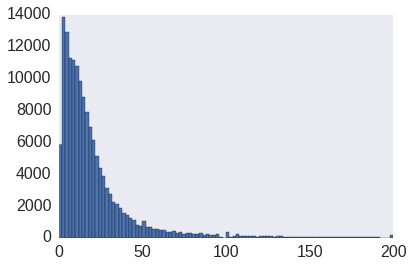

In [8]:
band = '670'
xdata = rrsPercUncStd358Dict[band]*100
ydata = lt358Dict[band]
thresh=10
print(xdata[xdata>0].min(),xdata.max())
print(ydata.min(),ydata.max())
print('PercOK: %.2f%%' % (xdata[xdata<=5].size / xdata.size * 100))
pl.hist(xdata,bins=100,range=(0,200));

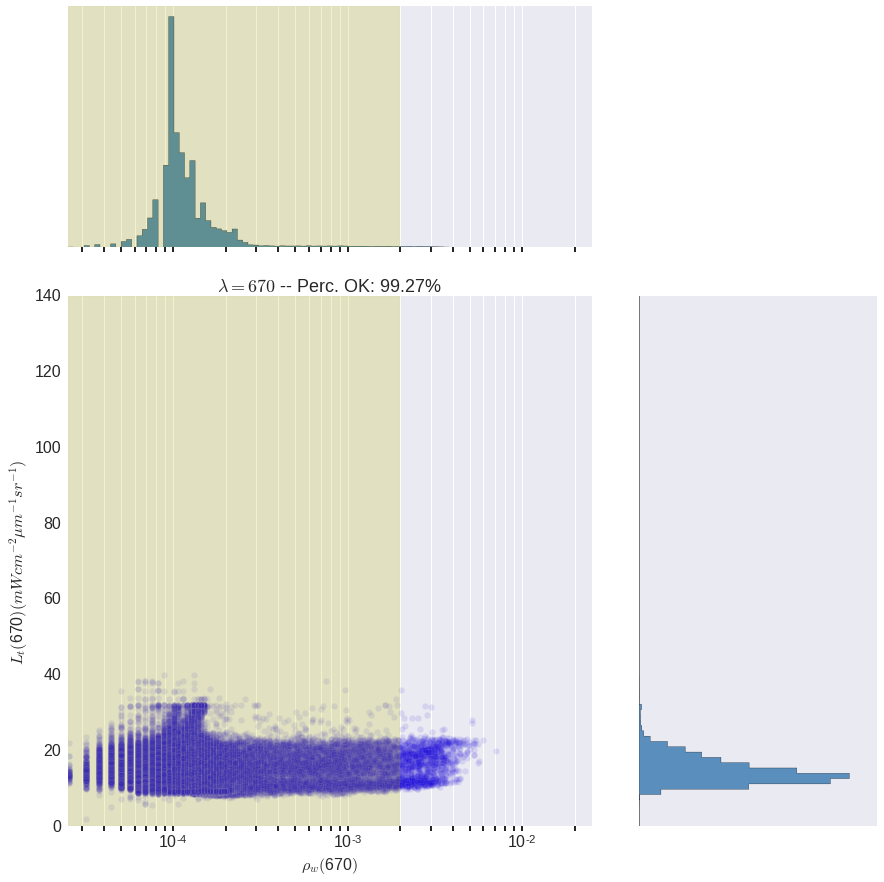

In [28]:
## NEAD TO WRITE A FUNCTION TO SHADE DATA WITHIN THRESHOLD
#def JointPlot(xdata,ydata,band,absolute=True)
band = '670'
yrange=(0,140)
absolute = True
ydata = lt358Dict[band]

colors=sb.xkcd_rgb

absRngDict={'412':(2.5e-5,0.025),'443':(2.5e-5,0.025),'490':(2.5e-5,0.025),
        '510':(2.5e-5,0.025),'555':(2.5e-5,0.025),'670':(2.5e-5,0.025)}
percRngDict={'412':(3e-1,30),'443':(3e-1,30),'490':(3e-1,20),
         '510':(3e-1,20),'555':(4e-1,50),'670':(5e-1,500)}
#percRngDict={'412':(0,20),'443':(0,10),'490':(0,10),
 #           '510':(0,10),'555':(0,20),'670':(0,150)}
rrsUncTreshDict = {'412':0.001,'443':0.001,'490':0.001,
                 '510':0.001,'555':0.001,'670':0.002}
rrsPercThreshDict = {'412':5,'443':5,'490':5,
                 '510':5,'555':5,'670':10}
minorLocator = LogLocator(subs=np.arange(2,11)/10)
rcParams['xtick.minor.visible'] = True
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.width'] = 2
rcParams['xtick.direction'] = 'Down'
if absolute:
    xdata = rrsUncStd358Dict[band] * np.pi
    thresh = rrsUncTreshDict[band]
    rrsRng = absRngDict[band]
    logBins = np.logspace(np.log10(rrsRng[0]),np.log10(rrsRng[1]),100)
    usebins = logBins
    scl='log'
    savename = 'JointAbs' + band
    xlabel1=r'$\rho_w($' + band + r'$)$'
else:
    xdata = rrsPercUncStd358Dict[band] * 100
    thresh = rrsPercThreshDict[band]
    rrsRng=percRngDict[band]
    logBins = np.logspace(np.log10(rrsRng[0]),np.log10(rrsRng[1]),100)
    usebins=logBins
    scl='log'
    savename = 'JointPerc' + band
    xlabel2= '% reflectance uncertainty (' + band + ')' 
percOK = 100*xdata[xdata<thresh].size/xdata.size

g1 = sb.JointGrid(x=xdata,y=ydata,
                 ratio=2,xlim=rrsRng,ylim=yrange,size=12)
_ = g1.plot_joint(pl.scatter,s=40,edgecolor='w',alpha=0.1,color=colors['ultramarine blue'])
g1.ax_joint.axvspan(xmin=rrsRng[0],xmax=thresh,color='y',alpha=0.2)
g1.ax_joint.xaxis.grid(True,which='minor')
g1.ax_joint.xaxis.set_minor_locator(minorLocator)
g1.ax_joint.set_xscale(scl)
pl.title('$\lambda = %s$ -- Perc. OK: %.2f%%' % (band, percOK),fontsize=fontSize + 2)
_ = g1.ax_marg_x.hist(xdata,bins=usebins,range=rrsRng,
                      histtype='stepfilled',color=colors['cool blue'])
_ = g1.ax_marg_y.hist(ydata,bins=100,range=yrange,alpha=0.9,
                      orientation='horizontal',histtype='stepfilled',
                     color=colors['cool blue'])
g1.ax_marg_x.set_xscale(scl)
g1.ax_marg_x.xaxis.grid(True,which='minor')
g1.ax_marg_x.xaxis.set_minor_locator(minorLocator)
ylabel=r'$L_t($' + band + r'$) (mW cm^{-2} \mu m^{-1} sr^{-1})$'
g1.ax_marg_x.axvspan(xmin=rrsRng[0],xmax=thresh,color='y',alpha=0.2);
if absolute: 
    xlbl=xlabel1
else:
    xlbl=xlabel2
g1.set_axis_labels(xlabel=xlbl,ylabel=ylabel,fontsize=fontSize)

g1.savefig('./PACEREVIEWFIGS/S1999358235554/' + savename,format='png')
del g1

In [29]:
# compare chlorophyll between the two scenes
fpStd358 = mainDir + 'S1999358223554/Standard/S1999358223554_silent.L2'
fpStd229 = mainDir + 'S1999229224418/Standard/S1999229224418_silent.L2'
with nc.Dataset(fpStd229) as ds:
    gv = ds.groups['geophysical_data'].variables
    print(gv.keys())
    chl229 = gv['chlor_a'][:]
with nc.Dataset(fpStd358) as ds:
    gv = ds.groups['geophysical_data'].variables
    chl358 = gv['chlor_a'][:]

odict_keys(['Lt_412', 'Lt_443', 'Lt_490', 'Lt_510', 'Lt_555', 'Lt_670', 'Lt_765', 'Lt_865', 'solz', 'sola', 'senz', 'sena', 'Rrs_412', 'Rrs_443', 'Rrs_490', 'Rrs_510', 'Rrs_555', 'Rrs_670', 'Rrs_765', 'Rrs_865', 'chlor_a', 'a_412_qaa', 'a_443_qaa', 'a_490_qaa', 'a_510_qaa', 'a_555_qaa', 'a_670_qaa', 'a_765_qaa', 'a_865_qaa', 'bb_412_qaa', 'bb_443_qaa', 'bb_490_qaa', 'bb_510_qaa', 'bb_555_qaa', 'bb_670_qaa', 'bb_765_qaa', 'bb_865_qaa', 'aot_865', 'owtd', 'l2_flags', 'Rrs_unc_412', 'Rrs_unc_443', 'Rrs_unc_490', 'Rrs_unc_510', 'Rrs_unc_555', 'Rrs_unc_670', 'Rrs_unc_765', 'Rrs_unc_865'])


In [58]:
ds=nc.Dataset(fpStd229)

In [61]:
gp=ds.groups['geophysical_data']

In [64]:
gp.variables['chlor_a']

<class 'netCDF4._netCDF4.Variable'>
float32 chlor_a(number_of_lines, pixels_per_line)
    long_name: Chlorophyll Concentration, OCI Algorithm
    units: mg m^-3
    standard_name: mass_concentration_chlorophyll_concentration_in_sea_water
    _FillValue: -32767.0
    valid_min: 0.001
    valid_max: 100.0
    reference: Hu, C., Lee Z., and Franz, B.A. (2012). Chlorophyll-a algorithms for oligotrophic oceans: A novel approach based on three-band reflectance difference, J. Geophys. Res., 117, C01011, doi:10.1029/2011JC007395.
path = /geophysical_data
unlimited dimensions: 
current shape = (3600, 248)
filling on

In [42]:
print(chl358.min(),chl358.max())
print(chl229.min(),chl229.max())

0.001 1000.0
0.001 1000.0


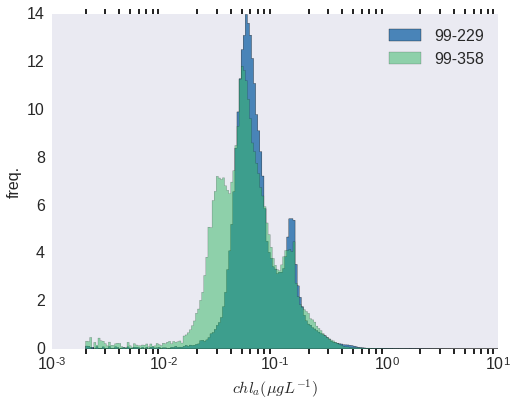

In [65]:
chlRng=(2e-3,10)
chlLogBins = np.logspace(np.log10(chlRng[0]),np.log10(chlRng[1]),200)
f,ax=pl.subplots(figsize=(8,6))
ax.hist(chl229.compressed(),bins=chlLogBins,range=chlRng,
        histtype='stepfilled',color=colors['cool blue'],normed=True,label='99-229');
ax.hist(chl358.compressed(),bins=chlLogBins,range=chlRng,
       histtype='stepfilled',color=colors['cool green'],alpha=0.5,normed=True,label='99-358')
ax.set_xscale('log');
ax.legend(fontsize=fontSize)

ax.set_xlabel(r'$chl_a(\mu gL^{-1})$',fontsize=fontSize)
ax.set_ylabel('freq.',fontsize=fontSize);
pl.savefig('ChlComp_229-358',format='png')